# Unconstrained Optimization
Ricardo A. Fernandes ricardoaf@lccv.ufal.br

Advisor: Professor Adeildo S. Ramos Jr

## Rosenbrock's function

$f\left(\boldsymbol{x}\right) = \left(a - x_1\right)^2 + b\left(x_2 - x_1^2\right)^2$

- Developed by Rosenbrock in 1960
- Well-known unconstrained test function
- Is has a minimum inside a long curved valley
- Some algorithms may have difficulties traversing along the valley to the global minimum
- The global minimum is [$a$, $a^2$], at which $f\left(\boldsymbol{x}^{*}\right) = 0$

In [1]:
rosenbrock(x; a=1, b=100) = (a-x[1])^2 + b*(x[2] - x[1]^2)^2;

In [2]:
using ForwardDiff
∇rosenbrock(x) = ForwardDiff.gradient(rosenbrock,x)
Hrosenbrock(x) = ForwardDiff.hessian(rosenbrock,x)

Hrosenbrock (generic function with 1 method)

## Line Search Algorithms

In [3]:
using LinearAlgebra, Optim

In [4]:
# Find bracket!
function bracket_minimum(f, x=0; s=1e-2, k=2.0)
    a, ya = x, f(x)
    b, yb = a + s, f(a + s)
    if yb > ya
        a, b = b, a
        ya, yb = yb, ya
        s = -s
        end
    while true
        c, yc = b + s, f(b + s)
        if yc > yb
            return a < c ? (a, c) : (c, a)
        end
        a, ya, b, yb = b, yb, c, yc
        s *= k
    end
end;

In [5]:
φ = MathConstants.φ
function golden_section_search(f, a, b, n)
    #φ=Base.MathConstants.golden
    ρ = φ-1
    d = ρ * b + (1 - ρ)*a
    yd = f(d)
    for i = 1 : n-1
        c = ρ*a + (1 - ρ)*b
        yc = f(c)
        if yc < yd
            b, d, yd = d, c, yc
        else
            a, b = b, c
        end
    end
    return a < b ? (a, b) : (b, a)
end;

In [6]:
function backtracking_line_search(f, ∇f, x, d, α; p=0.5, β=1e-4)
    y, g = f(x), ∇f(x)
    while f(x + α*d) > y + β*α*(g'*d)
        α *= p
    end
    α
end;

In [7]:
# See pg 62 from Algorithms for Optimization book
function strong_backtracking(f, ∇, x, d; α=1, β=1e-4, σ=0.1)
    y0, g0, y_prev, α_prev = f(x), ∇(x)'*d, NaN, 0
    αlo, αhi = NaN, NaN

    # bracket phase
    while true
        y = f(x + α*d)
        if y > y0 + β*α*g0 || (!isnan(y_prev) && y ≥ y_prev)
            αlo, αhi = α_prev, α
            break
        end
        g = ∇(x + α*d)'*d
        if abs(g) ≤ -σ*g0
            return α
        elseif g ≥ 0
            αlo, αhi = α, α_prev
            break
        end
        y_prev, α_prev, α = y, α, 2α
    end

    # zoom phase
    #println("Zoom")
    ylo = f(x + αlo*d)
    while true
        α = (αlo + αhi)/2
        y = f(x + α*d)
        if y > y0 + β*α*g0 || y ≥ ylo
            αhi = α
        else
            g = ∇(x + α*d)'*d
            if abs(g) ≤ -σ*g0
                return α
            elseif g*(αhi - αlo) ≥ 0
                αhi = αlo
            end
            αlo = α
        end
    end
end;

## Steepest Descent

In [8]:
function steepest_descent(f, ∇f, x0; tol=1e-6, maxitr=100000)
    
    # Init data
    ite = 0; x = x0; conv = false; err = 0
    xh = zeros(length(x0), maxitr+1); xh[:, 1] = x0;
    
    # Iterations
    while ite < maxitr
        
        # search direction
        d = -∇f(x)
        if any(isfinite.(d).==false); break; end
        
        # line search
        
        # Bracket the minimum
        ϕ(α) = f(x+α*d)
        a,b=bracket_minimum(ϕ)
        
        #Inexact
        α = backtracking_line_search(f, ∇f, x, d, b; p=0.5, β=1e-4) # Armijo line search
        # Exact
        #α,ℓ = golden_section_search(ϕ, a, b, 10)
        # α = optimize(ϕ, a, b,GoldenSection())
        
        # update x
        Δx = α * d;
        x += Δx
        
        # update ite and x history
        ite += 1
        xh[:, ite+1] = x
        
        # local minimum point
        err = norm(Δx); if err < tol; conv=true; break; end
    end
    
    # return x history, convergence and error
    return xh[:, 1:ite+1], conv, err
end;

## Conjugate Gradient

In [9]:
function conjugate_gradient(f, ∇f, x0; tol=1e-6, maxitr=10000)
    
    # Init data
    ite = 0; x = x0; conv = false; err = 0;
    xh = zeros(length(x0), maxitr+1); xh[:, 1] = x0;
    
    # Init conjugate gradient parameters
    g = ∇f(x); d = -g;
    d′, g′ = d, g
    
    # Iterations
    while ite < maxitr
        
        # search direction
        if ite > 0
            g′ = ∇f(x)
            β  = max(0, (g′ ⋅ (g′ - g)) / (g ⋅ g)) # Polak-Ribiere
            d′ = -g′ + β * d
        end
        if any(isfinite.(d′).==false); break; end
        
        # line search
        # Bracket the minimum
        ϕ(α) = f(x+α*d′)
        a,b=bracket_minimum(ϕ)
        
        # Inexact
        # α = backtracking_line_search(f, ∇f, x, d′, b; p=0.5, β=1e-4) # Inexact line search (Armijo)
        # α = strong_backtracking(f, ∇f, x, d′; α=1, β=1e-4, σ=0.1) # Inexact line search (Strong Wolf)
        
        # Exact
        ϕ(α) = f(x+α*d′)
        a,b=bracket_minimum(ϕ)
        α,ℓ = golden_section_search(ϕ, a, b, 100) # Exact line search: Golden Section
        # α = optimize(ϕ, a, b, GoldenSection()).minimizer # Golden Section
        # α = optimize(ϕ, a, b).minimizer # Exact line search: Brent

        # update x
        Δx = α * d′;
        x += Δx
        
        # update conjugate gradient parameters
        d, g = d′, g′
        
        # update ite and x history
        ite += 1
        xh[:, ite+1] = x
        
        # local minimum point
        err = norm(Δx); if err < tol; conv=true; break; end
    end
    
    # return x history, convergence and error
    return xh[:, 1:ite+1], conv, err
end;

## Newton

In [10]:
function newton(f, ∇f, H, x0; tol=1e-6, maxitr=100)
    
    # Init data
    ite = 0; x = x0; conv = false; err = 0
    xh = zeros(length(x0), maxitr+1); xh[:, 1] = x0;
    
    # Iterations
    while ite < maxitr
        
        # search direction
        g = ∇f(x)
        d = -H(x) \ g
        if any(isfinite.(d).==false); break; end
        
        # line search
        #α = backtracking_line_search(f, ∇f, x, d, 1; p=0.5, β=1e-4) # Inexact line search (Armijo)
        α = strong_backtracking(f, ∇f, x, d; α=1, β=1e-4, σ=0.1) # Inexact line search (Strong Wolf)
        #ϕ(α) = f(x+α*d)
        #α = optimize(ϕ, 0., 10).minimizer # Exact line search: Brent
        
        # update x
        Δx = α * d;
        x += Δx
        
        # update ite and x history
        ite += 1
        xh[:, ite+1] = x
        
        # local minimum point
        err = norm(Δx); if err < tol; conv=true; break; end
    end
    
    # return x history, convergence and error
    return xh[:, 1:ite+1], conv, err
end;

## Evaluating methods

In [11]:
# Initial guess
#x0 = [0., 0.]
x0 = [-1.2, 1.0]

# post process function
function post_process(name, xh, conv, err)
    println(); println(name)
    println("conv? : ", conv)
    println("# ite : ", size(xh, 2)-1)
    println("  err : ", err)
    println("   x* : ", xh[:, end])
    println("f(x*) : ", rosenbrock(xh[:, end]))
end

# Eval steepest-descent
@time xh_sd, conv_sd, err_sd = steepest_descent(rosenbrock, ∇rosenbrock, x0)
post_process("steepest-descent", xh_sd, conv_sd, err_sd)

# Eval conjugate-gradient
@time xh_cg, conv_cg, err_cg = conjugate_gradient(rosenbrock, ∇rosenbrock, x0)
post_process("conjugate-gradient", xh_cg, conv_cg, err_cg)

# Eval newton
@time xh_n, conv_n, err_n = newton(rosenbrock, ∇rosenbrock, Hrosenbrock, x0)
post_process("newton", xh_n, conv_n, err_n)
#det(Hrosenbrock(x0))
Hrosenbrock(x0)

  1.321890 seconds (4.99 M allocations: 256.690 MiB, 11.68% gc time)

steepest-descent
conv? : true
# ite : 5014
  err : 9.892032600160586e-7
   x* : [0.9996582998954174, 0.9993145071241247]
f(x*) : 1.172471176515861e-7
  0.163129 seconds (389.32 k allocations: 19.213 MiB)

conjugate-gradient
conv? : true
# ite : 22
  err : 2.761653952165487e-11
   x* : [0.9999999999993988, 0.9999999999987976]
f(x*) : 3.614243274467841e-25
  1.575197 seconds (6.54 M allocations: 333.092 MiB, 4.02% gc time)

newton
conv? : true
# ite : 15
  err : 7.394667791843335e-12
   x* : [1.0, 1.0]
f(x*) : 0.0


2×2 Array{Float64,2}:
 1330.0  480.0
  480.0  200.0

In [12]:
using Plots

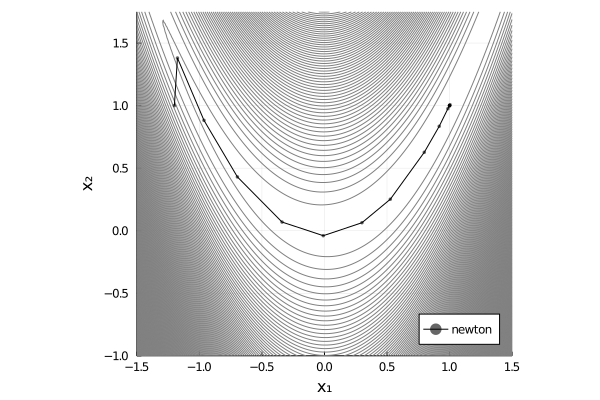

In [13]:
gr(xlabel="x₁", ylabel="x₂", aspect_ratio=:equal, legend=:bottomright, colorbar=false)
xlim = (-1.5, 1.50); x = LinRange(xlim[1], xlim[2], 200)
ylim = (-1.0, 1.75); y = LinRange(ylim[1], ylim[2], 200)
contour(x, y, (x, y)->rosenbrock([x, y]), levels=200, c=:grey, xlim=xlim, ylim=ylim)

# plot!(xh_sd[1,:], xh_sd[2,:], marker = (:c, 2, 0.6), c=:red, label="steepest-descent")
# plot!(xh_cg[1,:], xh_cg[2,:], marker = (:c, 2, 0.6), c=:blue, label="conjugate-gradient")
plot!(xh_n[1,:], xh_n[2,:], marker = (:c, 2, 0.6), c=:black, label="newton")